# Hypothesis testing using Configuration Model
In this notebook we're going to use the Configruation Model to cretae reference networks for hypothesis testing.

## Setup
First we import some libraries and define useful auxiliary functions

In [4]:
import networkx as nx
import numpy as np
import os
import sys
from collections import defaultdict
import matplotlib.pyplot as plt
from typing import Callable, Tuple, List, Dict, Any, Set, Optional

In [5]:
module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
from graphutil.print import print_network_information
from graphutil.visualization import draw_graph_and_color_groups

In [7]:
def separate_nodes_by_attribute(graph: nx.Graph, attribute: str) -> List[Set[Any]]:
    """Teilt die Knoten eines Graphen nach einem bestimmten Attribut in Gruppen ein.

    Args:
        graph (nx.Graph): Der zu analysierende Graph.
        attribute (str): Der Name des Attributes, nach dem die Knoten gruppiert werden sollen.

    Returns:
        List[Set[Any]]: Eine Liste von Mengen, wobei jede Menge Knoten mit dem gleichen Attributwert enthält.
    """
    attribute_groups = defaultdict(set)
    
    for node, data in graph.nodes(data=True):
        if attribute in data:
            attribute_value = data[attribute]
            attribute_groups[attribute_value].add(node)
    
    return list(attribute_groups.values())

In [8]:
def apply_permutation_test(
    original_network: nx.Graph, 
    metric_function: Callable[[nx.Graph], float], 
    metric_name: str, 
    num_permutations: int = 10000, 
    alpha: float = 0.05
) -> Tuple[float, List[float], float, float]:
    """Führt einen Permutationstest für eine gegebene Netzwerkmessung durch.

    Args:
        original_network (nx.Graph): Das Originalnetzwerk.
        metric_function (Callable[[nx.Graph], float]): Funktion zur Berechnung der Netzwerkmessung.
        metric_name (str): Name der Netzwerkmessung.
        num_permutations (int, optional): Anzahl der Permutationen. Standard ist 10000.
        alpha (float, optional): Signifikanzniveau. Standard ist 0.05.

    Returns:
        Tuple[float, List[float], float, float]: Beobachteter Messwert, Liste der permutierten Messwerte,
                                                  Mittelwert und Standardabweichung der permutierten Messwerte.
    """
    # Beobachtete Assortativität berechnen
    observed_metric_value = metric_function(original_network)
    print(f"Beobachtete {metric_name}: {observed_metric_value}")
    
    # Anzahl der Permutationen
    metric_values_on_permutations = []
    
    for _ in range(num_permutations):
        # Erstellen eines zufälligen Netzwerks mit der gleichen Gradverteilung
        permuted_graph = nx.configuration_model([d for _, d in original_network.degree()])
        permuted_graph = nx.Graph(permuted_graph)
        permuted_graph.remove_edges_from(nx.selfloop_edges(permuted_graph))  # Self-Loops entfernen
        
        # Alle Attribute der Knoten ermitteln
        node_attributes = {attr for _, data in original_network.nodes(data=True) for attr in data}
        
        # Jedes Attribut zufällig permutieren und im neuen Graphen setzen
        for attr in node_attributes:
            attributes = list(nx.get_node_attributes(original_network, attr).values())
            np.random.shuffle(attributes)
            nx.set_node_attributes(permuted_graph, dict(zip(permuted_graph.nodes(), attributes)), attr)
        
        # Berechnen der Assortativität für das zufällige Netzwerk
        metric_values_on_permutations.append(metric_function(permuted_graph))
    
    # Berechnung des p-Wertes
    metric_values_on_permutations_np = np.array(metric_values_on_permutations)
    p_value_greater = (np.sum(metric_values_on_permutations_np >= observed_metric_value) + 1) / (num_permutations + 1)
    p_value_less = (np.sum(metric_values_on_permutations_np <= observed_metric_value) + 1) / (num_permutations + 1)

    mean_permuted = np.mean(metric_values_on_permutations_np)
    #std_permuted = np.std(metric_values_on_permutations_np)

    if p_value_greater < alpha:
        print(f"{metric_name} ist signifikant größer als die zufällig permutierten Werte. Der p-Wert ist: {p_value_greater:.10f}")
    elif p_value_less < alpha:
        print(f"{metric_name} ist signifikant kleiner als die zufällig permutierten Werte. Der p-Wert ist: {p_value_less:.10f}")
    else:
        print("Die Assortativität ist nicht signifikant unterschiedlich von den zufällig permutierten Werten.")

    plot_permutation_test_result(observed_metric_value, metric_values_on_permutations, metric_name, mean_permuted)

In [60]:
def plot_permutation_test_result(
    observed_value: float, 
    permuted_values: List[float], 
    metric: str, 
    mean_permuted: Optional[float] = None, 
    num_bins: int = 30
) -> None:
    """Visualisiert die Ergebnisse eines Permutationstests.

    Args:
        observed_value (float): Der beobachtete Wert der Metrik im Originalnetzwerk.
        permuted_values (List[float]): Eine Liste der Metrikwerte aus den permutierten Netzwerken.
        metric (str): Der Name der Metrik.
        mean_permuted (Optional[float], optional): Der Mittelwert der permutierten Metrikwerte. Standard ist None.
        num_bins (int, optional): Die Anzahl der Bins im Histogramm. Standard ist 30.
    """
    # Visualisierung der Ergebnisse
    plt.hist(permuted_values, bins=num_bins, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(observed_value, color='red', linestyle='dashed', linewidth=2, label=f'Beobachtete {metric} ({observed_value:.5f})')
    
    # Optionaler Mittelwert der permutierten Werte
    if mean_permuted is not None:
        plt.axvline(mean_permuted, color='black', linestyle='dotted', linewidth=2, 
                    label=f'Mittelwert der {metric} ({mean_permuted:.5f})')
    
    plt.xlabel(f'{metric} auf den {len(permuted_values)} Permutationen')
    plt.ylabel('Häufigkeit')
    plt.title(f'Verteilung der {metric} in den Referenznetzwerken')
    plt.legend()
    plt.show()

# Loading the Karate Club graph

Each node in the returned graph has a node attribute ‘club’ that indicates the name of the club to which the member represented by that node belongs, either ‘Mr. Hi’ or ‘Officer’. Each edge has a weight based on the number of contexts in which that edge’s incident node members interacted.

In [12]:
G_Karate = nx.karate_club_graph()

In [13]:
print_network_information(G_Karate)

Information for given Graph with name 'Zachary's Karate Club':
	Graph is directed: False
	Number of nodes: 34
	Number of edges: 78


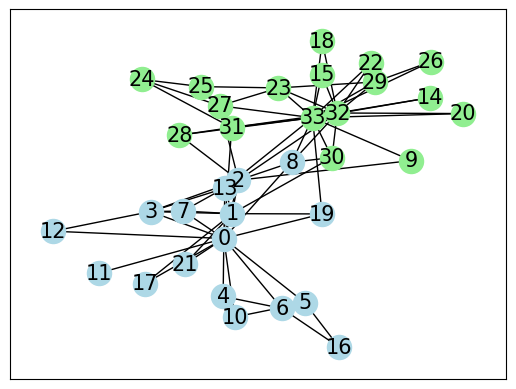

In [62]:
clubs = separate_nodes_by_attribute(G_Karate, "club")
draw_graph_and_color_groups(G_Karate, clubs, layout="spring")

## Investigating club attribute assortativity on Karate Club Network

Keep in mind that the default implementation of networkX does not consider the edge weight attribute for calculating the assortativity value. Each edge is considered to have edge weight 1. If you want to consider the edge weight you need to apply QAP.

Beobachtete Club Assortativity: 0.717530864197531
Club Assortativity ist signifikant größer als die zufällig permutierten Werte. Der p-Wert ist: 0.0000999900


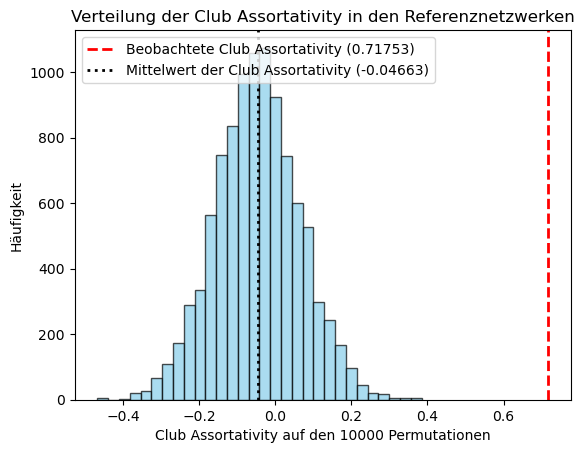

In [66]:
metric_function = lambda G: nx.attribute_assortativity_coefficient(G, "club")
metric_name = "Club Assortativity"
apply_permutation_test(G_Karate, metric_function, metric_name)

## Investigating the degere assortativity on Karate Club Network

Beobachtete Degree Assortativity: -0.47561309768461413
Degree Assortativity ist signifikant kleiner als die zufällig permutierten Werte. Der p-Wert ist: 0.0001999800


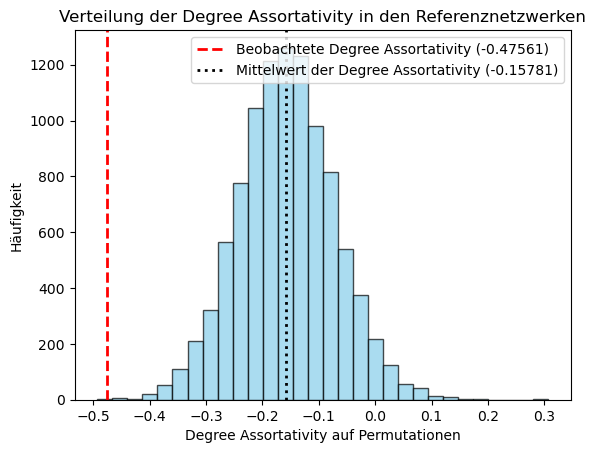

In [19]:
metric_function = lambda x: nx.degree_assortativity_coefficient(x)
metric_name = "Degree Assortativity"
apply_permutation_test(G_Karate, metric_function, metric_name)

## Investigating the number of Triangles on Karate Club Network

Beobachtete Number of Triangles: 135
Number of Triangles ist signifikant größer als die zufällig permutierten Werte. Der p-Wert ist: 0.0000999900


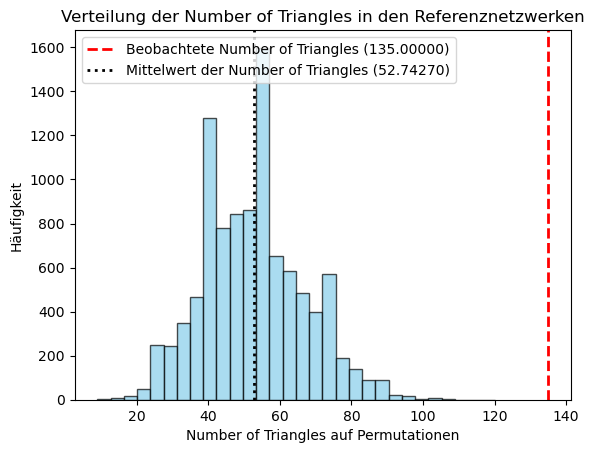

In [21]:
metric_function = lambda G: sum(nx.triangles(G).values())
metric_name = "Number of Triangles"
apply_permutation_test(G_Karate, metric_function, metric_name)

## Investigating the Clustering Coefficient on Karate Club Network

Beobachtete Clustering Coefficient: 0.5706384782076823
Clustering Coefficient ist signifikant größer als die zufällig permutierten Werte. Der p-Wert ist: 0.0000999900


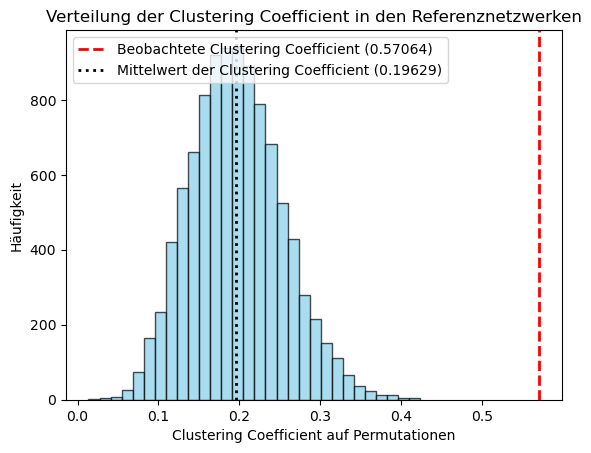

In [23]:
metric_function = lambda G: nx.average_clustering(G)
metric_name = "Clustering Coefficient"
apply_permutation_test(G_Karate, metric_function, metric_name)

## Investigating the Diameter on Karate Club Network

In [58]:
metric_function = lambda G: nx.diameter(G)
metric_name = "Clustering Coefficient"
apply_permutation_test(G_Karate, metric_function, metric_name)

Beobachtete Clustering Coefficient: 5


NetworkXError: Found infinite path length because the graph is not connected

# Schoolday Network

In [25]:
G_School = nx.read_gexf("../../data/sp_data_school_day_1_g.gexf")

In [26]:
print_network_information(G_School)

Information for given Graph with name '':
	Graph is directed: False
	Number of nodes: 236
	Number of edges: 5899


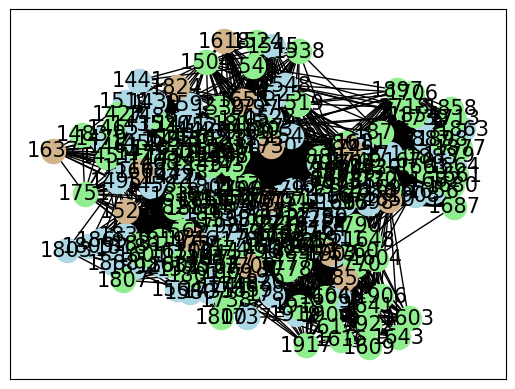

In [27]:
school_class_genders = separate_nodes_by_attribute(G_School, "gender")
draw_graph_and_color_groups(G_School, school_class_genders, layout="spring")

## Gender Assortativity on Schoolday Network

Beobachtete Gender Assortativity: 0.05401318039531291
Gender Assortativity ist signifikant größer als die zufällig permutierten Werte. Der p-Wert ist: 0.0009990010


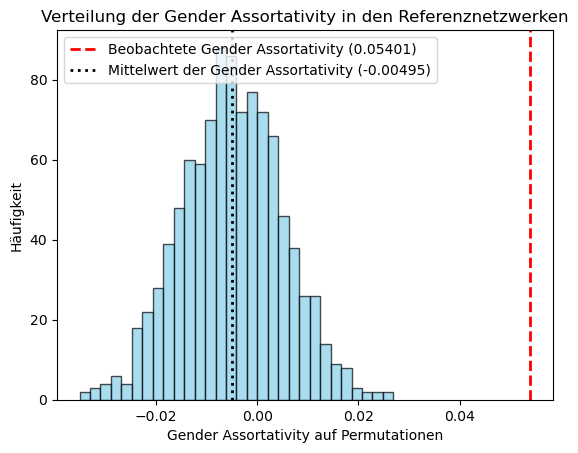

In [29]:
metric_function = lambda x: nx.attribute_assortativity_coefficient(x, "gender")
metric_name = "Gender Assortativity"
apply_permutation_test(G_School, metric_function, metric_name, num_permutations=1000)

 ## Class Assortativity on Schoolday Network

Beobachtete Class Assortativity: 0.3242287558206471
Class Assortativity ist signifikant größer als die zufällig permutierten Werte. Der p-Wert ist: 0.0009990010


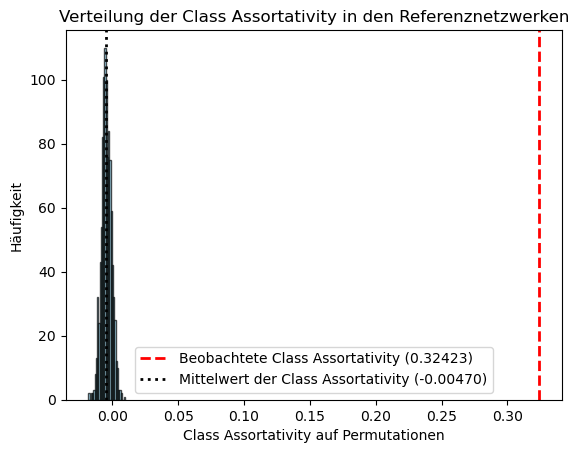

In [31]:
metric_function = lambda x: nx.attribute_assortativity_coefficient(x, "classname")
metric_name = "Class Assortativity"
apply_permutation_test(G_School, metric_function, metric_name, num_permutations=1000)

 ## Triangle Analysis on Schoolday Network

Beobachtete Number of Triangles: 145203
Number of Triangles ist signifikant größer als die zufällig permutierten Werte. Der p-Wert ist: 0.0000999900


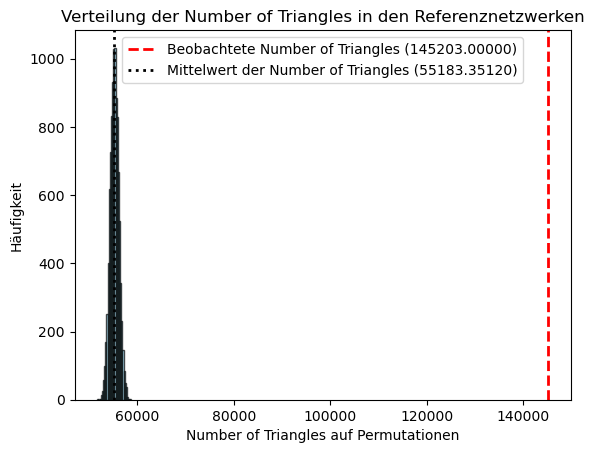

In [33]:
metric_function = lambda G: sum(nx.triangles(G).values())
metric_name = "Number of Triangles"
apply_permutation_test(G_School, metric_function, metric_name)